# Set root directory 

In [1]:
ROOT_DIR = 'test_data/'

# if you follow the docker instructions use this:
# ROOT_DIR = '/external_data/test_data'

# Basic Data Types 

In this notebook, we present the different data types that are currently available in MIIT. 

In [2]:
import os
from os.path import exists, join

import cv2
import SimpleITK as sitk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from miit.spatial_data.section import Section, register_to_ref_image
from miit.spatial_data.base_types import Image, Annotation, Pointset, OMETIFFImage
from miit.spatial_data.spatial_omics.imzml import Imzml
from miit.spatial_data.spatial_omics.visium import Visium
import pyimzml

In [3]:
if not exists('output_directory'):
    os.mkdir('output_directory')

## Load data and set up experiment

We start by loading all images, annotations and st data separetely. Images can be loaded with any arbitrary library (e.g. OpenCV, SKimage, SimpleITK). 

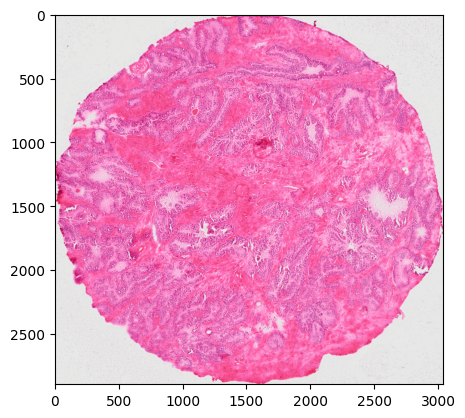

In [4]:
# Load the image first as an numpy array.
reference_image_np = cv2.imread(join(ROOT_DIR, 'test_data/source_data/7/images/image.tif'))
reference_image_np = cv2.cvtColor(reference_image_np, cv2.COLOR_BGR2RGB)



# ...and then put it inside an DefaultImage object. Optionally, a name can be supplied which can make it easier to handle a large amount of sections.
reference_image = Image(data=reference_image_np)

# ... or alternatively, read_directly from path
reference_image = Image.load_from_path(join(ROOT_DIR, 'test_data/source_data/7/images/image.tif'))

# Internally image data is stored as numpy arrays and can be accessed using the `data` attribute. We can use that for plotting, for instance.
plt.imshow(reference_image.data)

In [5]:
# We do this for all the other data types.
# Annotations are placed in Annotation objects.
# tissue_mask_np = sitk.GetArrayFromImage(sitk.ReadImage('../data/hist/section1/tissue_mask.tif'))
tissue_mask_np = sitk.GetArrayFromImage(sitk.ReadImage(join(ROOT_DIR, 'test_data/source_data/7/masks/tissue_mask.tif')))
tissue_mask = Annotation(data=tissue_mask_np, name='tissue_mask')

# ... or alternatively:
tissue_mask = Annotation.load_from_path(join(ROOT_DIR, 'test_data/source_data/7/masks/tissue_mask.tif'), name='tissue_mask')

# Optionally, labels can also be loaded and included in Annotations.
hist_annotations = Annotation.load_from_path(join(ROOT_DIR, 'test_data/source_data/7/annotations/annotations.nii.gz'),
                                              path_to_labels='test_data/test_data/source_data/7/annotations/labels.txt',
                                              channel_idx=0,
                                              name='hist_annotations')

# We can do this also by hand, if necessary
# histopathology_annotations_np = sitk.GetArrayFromImage(sitk.ReadImage('../data/hist/section1/labels.nii.gz'))
histopathology_annotations_np = sitk.GetArrayFromImage(sitk.ReadImage(join(ROOT_DIR, 'test_data/source_data/7/annotations/annotations.nii.gz')))
histopathology_annotations_np = np.moveaxis(histopathology_annotations_np, 0, 2)
with open(join(ROOT_DIR, 'test_data/source_data/7/annotations/labels.txt')) as f:
    histopathology_labels = [x.strip() for x in f.readlines()]

hist_annotations2 = Annotation(data=histopathology_annotations_np, labels=histopathology_labels, name='hist_annotations')


# histo_annotations and histo_annotations2 contain the same data
assert np.all(hist_annotations.data == hist_annotations2.data)

In [6]:
# The last of the standard annotation types are Pointsets.
# We start off by loading the data with a library of our choice. Internally, pointsets are processed as pandas dataframes, so we load them as such as well.
df = pd.read_csv(join(ROOT_DIR, 'test_data/source_data/7/landmarks/07.csv'), index_col='label')

# After loading successfully we can initialize a Pointset object. By definition, pointsets use 'x' and 'y' column names to determine pixel locations.
# If the dataframe uses different column names, those can be set in `x_axis` and `y_axis` arguments.
landmarks = Pointset(data=df, name='landmarks', index_col=0)
landmarks.data.head(5)

x            y
label                         
Pt-0   739.560093  1725.627076
Pt-1   270.583625  1667.566174
Pt-2   405.458686  2006.206250
Pt-3   256.864171  2004.706193
Pt-4   231.123689  1750.924836

In [7]:
# Or, we use MIIT's utility loader function
landmarks2 = Pointset.load_from_path(join(ROOT_DIR, 'test_data/source_data/7/landmarks/07.csv'), index_col='label')

assert np.all(landmarks.data == landmarks2.data)

In [8]:
# Now that we have the reference image and all additional datapoints, we can build sections.

section = Section(reference_image=reference_image,
                  annotations=[tissue_mask, hist_annotations, landmarks])

In [9]:
# To make it easier get find annotations again, we have a utility function to find the data in sections.
tissue_mask_from_section = section.get_annotations_by_names('tissue_mask')

Text(0.5, 1.0, 'Reference image + landmarks')

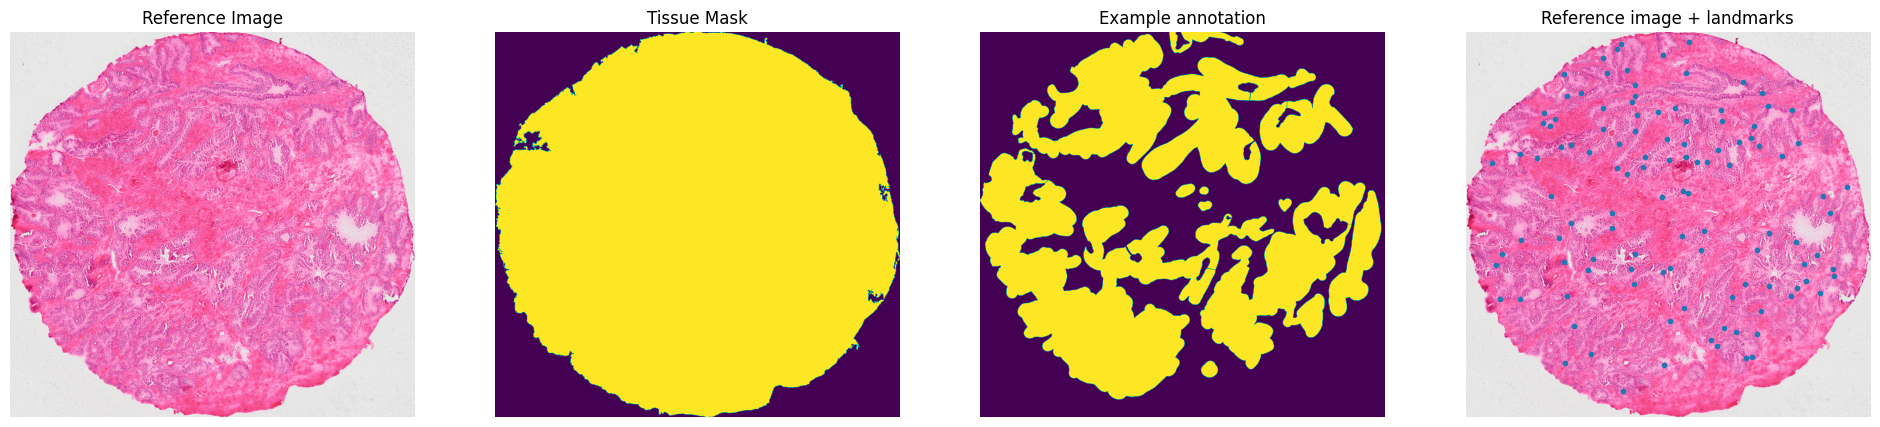

In [10]:
# We can illustrate the section.
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(section.reference_image.data)
axs[0].set_title('Reference Image')
axs[1].imshow(tissue_mask_from_section.data)
ann = section.get_annotations_by_names('hist_annotations')
axs[1].set_title('Tissue Mask')
axs[2].imshow(ann.data[:,:,2])
axs[2].set_title('Example annotation')
axs[3].imshow(section.reference_image.data)
ps = section.get_annotations_by_names('landmarks').to_numpy()
axs[3].plot(ps[:,0], ps[:,1], '.')
axs[3].set_title('Reference image + landmarks')

### Loading Visium data


In [11]:
# For Visium data we use data from a different histology section
reference_image = Image.load_from_path(join(ROOT_DIR, 'test_data/source_data/2/images/image.tif'))
tissue_mask = Annotation.load_from_path(join(ROOT_DIR, 'test_data/source_data/2/masks/tissue_mask.tif'))
section = Section(reference_image=reference_image)

In [12]:
# Now we start with loading Visium data. We use the helper classmethod `from_spcrng` to load all the data automatically.
st_data = Visium.from_spcrng(directory=join(ROOT_DIR, 'test_data/source_data/2/spatial_transcriptomics/'))

Text(0.5, 1.0, 'Visium Image')

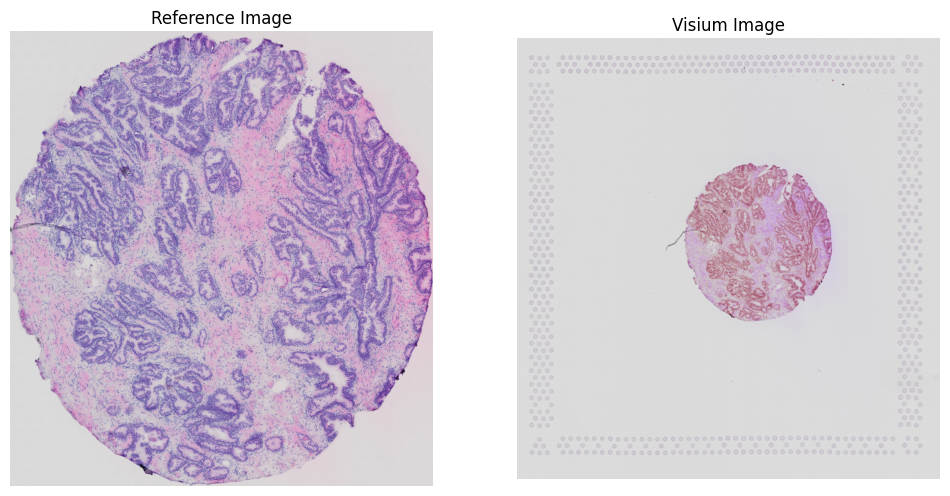

In [13]:
# We can compare both images now.
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(section.reference_image.data)
axs[0].set_title('Reference Image')
axs[1].imshow(st_data.image.data)
axs[1].set_title('Visium Image')

In [14]:
# We see that both image are differently cropped. All imaging data in a section should be spatially aligned, so we use
# a utility function for registering both images.

# `register_to_ref_image` relies on the OpenCVAffine registerer, though other registerers can be added.
warped_st_data, registered_image = register_to_ref_image(section.reference_image.data, st_data.image.data, st_data)

Text(0.5, 1.0, 'Registered Visium Image')

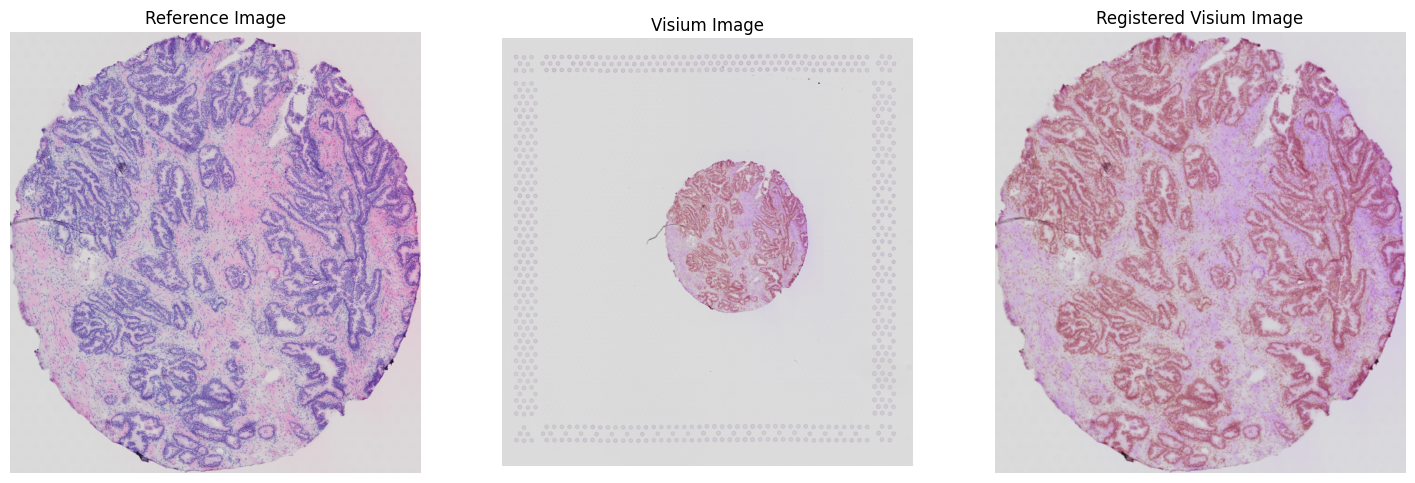

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(section.reference_image.data)
axs[0].set_title('Reference Image')
axs[1].imshow(st_data.image.data)
axs[1].set_title('Visium Image')
axs[2].imshow(registered_image.data)
axs[2].set_title('Registered Visium Image')

In [16]:
# Now that st data is registered, we can add it to sections.
section.so_data.append(warped_st_data)

In [17]:
# We also provide a summary function that lists all additional imaging data in a section.
section.print_additional_data_summary()

########################################################
# Name # ID                                   # Type   #
########################################################
#      # 90097e66-914f-11ef-b910-fa163eee643f # visium #
########################################################


BaseImaging objects support a few basic image operation (see source code for now).

### Loading MSI data

In the next example we show how to load msi data. We use the imzML format for handling msi data.

In [18]:
# We start out by simply using a classmethod for initializing imzml data

msi_hist_image_path = join(ROOT_DIR, 'test_data/source_data/7/images/image.tif')
msi_hist_image = Image.load_from_path(msi_hist_image_path)
imzml_path = join(ROOT_DIR, 'test_data/source_data/7/imzml/reduced_msi.imzML')
target_resolution = 1

imzml_neg_1 = Imzml.init_msi_data(imzml_path, target_resolution=target_resolution, name='negation ion mode')

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


Text(0.5, 1.0, 'MSI-Pixel distribution')

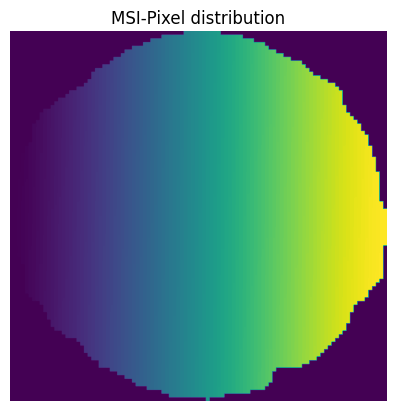

In [19]:
# The return of the conversion are a ref_mat, which is a matrix representation of the spatial distribution of 
# msi-pixels. spec_to_ref_map contains the mapping from each reference in `ref_mat` to its original msi-pixel.
# This mapping will be used internally in Imzml objects during integration.
plt.imshow(imzml_neg_1.ref_mat.data)
plt.axis('off')
plt.title('MSI-Pixel distribution')

MSI data might differ from the associated histology image a bit and need to be correctly aligned for downstream analysis.

First, we need an image presentation of the MSI data. We have 3 different options for this:
1. PCA image: Here, the first principal component of all msi spectra is used to derive an image.
2. Ion images: We can extract ion images from the MSI file if we have ions that correlate well with the histology.
3. Masks: We can also use masks that are exported with MSI data (e.g. from SCiLS) and use those as an image presentation.

In [20]:
imzml_neg_1.msi.getspectrum(0)

(array([174.8240924 , 191.01209831]), array([ 10.30494213, 317.56329346]))

Text(0.5, 1.0, 'Mask')

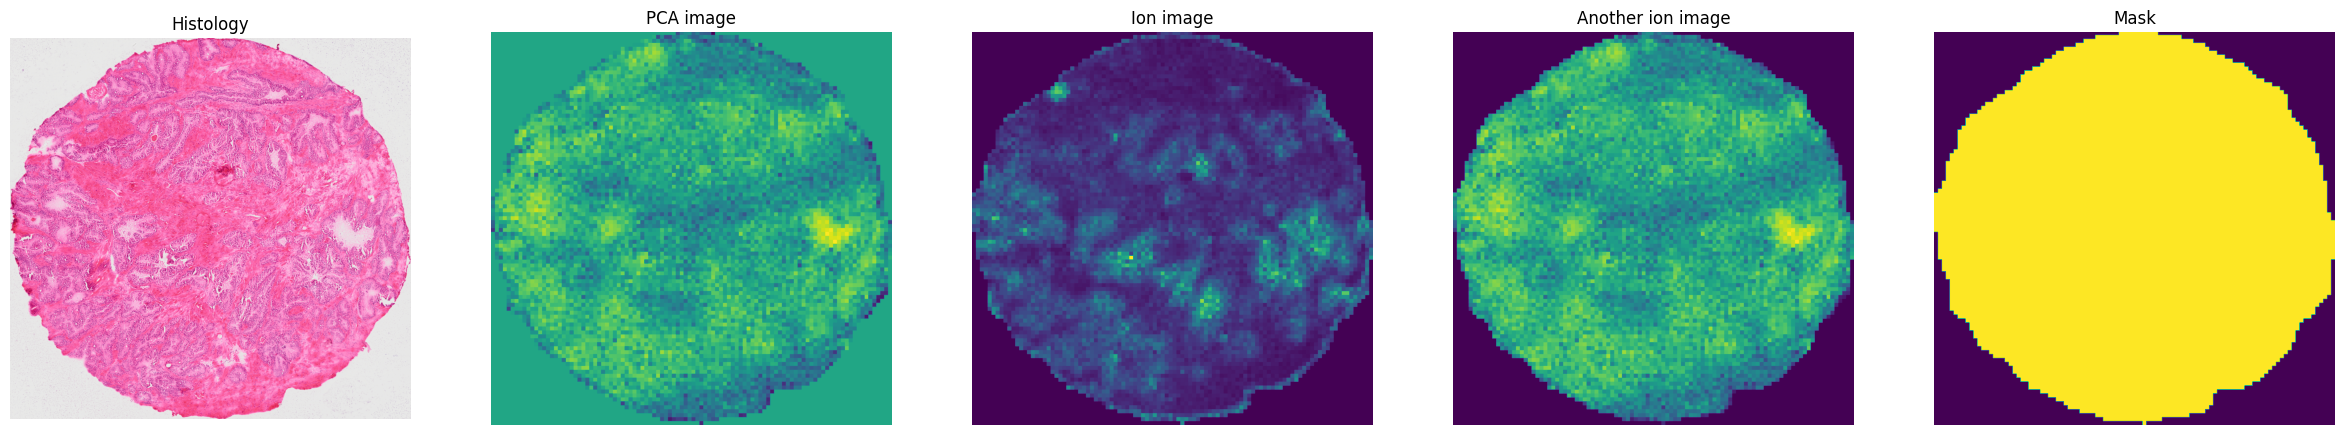

In [21]:
from miit.utils.scils import read_srd_with_msi

pca_img = imzml_neg_1.get_pca_img()

ion_image1 = imzml_neg_1.extract_ion_image_by_idx(0)
ion_image2 = imzml_neg_1.extract_ion_image(191.01209831)

mask = imzml_neg_1.ref_mat.data > imzml_neg_1.background

fig, axs = plt.subplots(1, 5, figsize=(6 * 5, 6 * 1))
for ax in axs:
    ax.axis('off')
axs[0].imshow(msi_hist_image.data)
axs[0].set_title('Histology')
axs[1].imshow(pca_img.data)
axs[1].set_title('PCA image')
axs[2].imshow(ion_image1.data)
axs[2].set_title('Ion image')
axs[3].imshow(ion_image2.data)
axs[3].set_title('Another ion image')
axs[4].imshow(mask)
axs[4].set_title('Mask')


Choosing the right image presentation is highly dependent of the use case.
Now that we have an image presentation, we can look at the registration. For the MSI registration to histology image, we have a custom registerer, which we named `MSItoHistMetaRegisterer`. Its called meta registerer, because this registration algorithm performs the preprocessing, but still needs a registration algorithm to the actual registration. By default, `MSItoHistMetaRegisterer` uses the `NiftyReg` registration algorihm.

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


Text(0.5, 1.0, 'PCA image after registration')

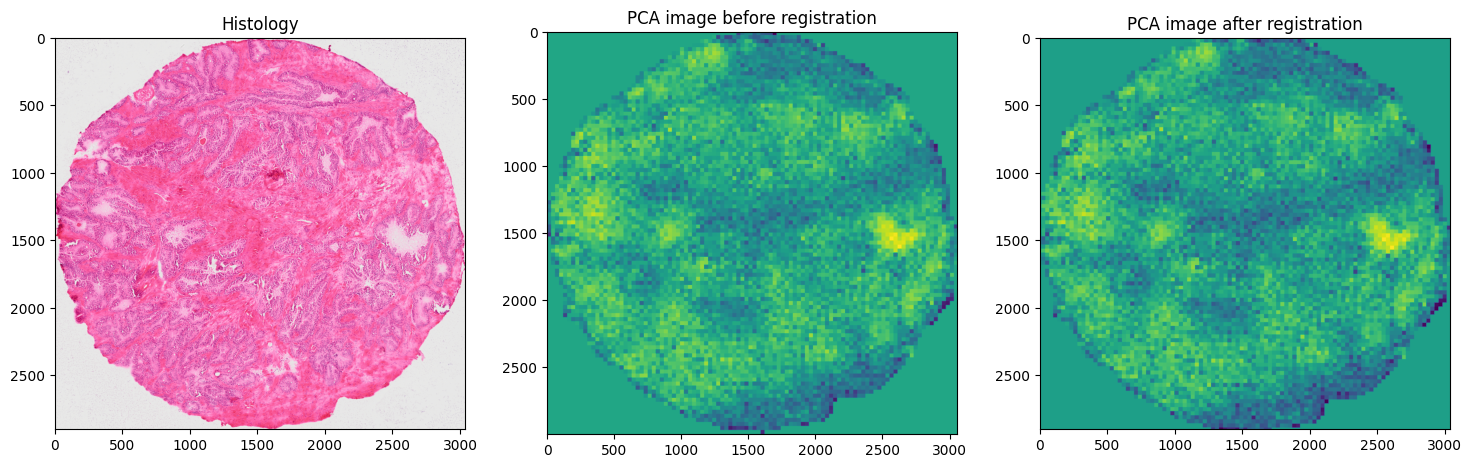

In [22]:
# Now, msi data might be offset a little bit from the histology image.For this case, we have a separate registration algorithm.
# By default, we use NiftyReg as a registration algorithm, though others can be supplied as well.
# For the registration, we derive an image presentation based on the PCA spectrum.
# We supply the ref_mat, so that the data can be transformed directly in the function.
from miit.registerers.other.msi_to_hist_meta_registerer import MSItoHistMetaRegisterer

registerer = MSItoHistMetaRegisterer()

warped_imzml_neg, warped_image = register_to_ref_image(msi_hist_image.data, 
                                                       pca_img.data, 
                                                       imzml_neg_1,
                                                       registerer=registerer)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(msi_hist_image.data)
axs[0].set_title('Histology')
axs[1].imshow(pca_img.data)
axs[1].set_title('PCA image before registration')
axs[2].imshow(warped_image.data)
axs[2].set_title('PCA image after registration')

In [23]:
section2 = Section()
section2.reference_image = msi_hist_image
section2.so_data.append(imzml_neg_1)

section2.print_additional_data_summary()

####################################################################
# Name              # ID                                   # Type  #
####################################################################
# negation ion mode # 9296b6da-914f-11ef-b910-fa163eee643f # Imzml #
####################################################################


### Storing and loading sections

MIIT has support for loading and storing imaging data types.

In [24]:
section.store('output_directory/tmp_store')

The output should look something that. This format is somewhat human readable. In `attributes.json` the mapping of each imaging type to `uuid` is documented.

```
.
├── 1855e684-9140-11ef-b86d-fa163eee643f
│   ├── attributes.json
│   └── image.nii.gz
├── 39127ee6-9140-11ef-b86d-fa163eee643f
│   ├── attributes.json
│   ├── config.json
│   ├── image
│   │   ├── attributes.json
│   │   └── image.nii.gz
│   ├── ref_mat
│   │   ├── additional_attributes.json
│   │   ├── annotations.nii.gz
│   │   └── labels.json
│   ├── scale_factors.json
│   ├── spec_to_ref_mat.json
│   └── table
│       ├── attributes.json
│       └── pointset.csv
├── attributes.json
└── meta_information.json
```

In [25]:
# Similarly, the data can be loaded using the load function.

loaded_section = Section.load('output_directory/tmp_store/')

### Adding new data types.

MIIT has support for adding new data types. For basic imaging types, we can add new data types by implementing either the `BaseImaging` or `BasePointset` interfaces. For
spatial omics datatypes that are more complex, the `BaseSpatialOmics` interface can be implemented.

If storing and loading of new datatypes should be supported, the new dataypes can be added to the `SpatialDataLoader` class. (example to follow soon.)